# Benchmark transcription rate prediction

Notebooks for benchmarking transcription rate prediction on metabolic labelled cell cycle datasets

## Library imports

In [78]:
import numpy as np
import pandas as pd
import scipy
import torch
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.plotting._significance import add_significance, get_significance

## Constants

In [2]:
DATASET = "cell_cycle_rpe1"

In [3]:
SAVE_DATA = True
SAVE_FIGURES = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Data loading

In [5]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_processed.h5ad")

In [ ]:
alpha = pd.read_csv(
    DATA_DIR / DATASET / "raw" / "aax3072_table-s1.csv", index_col=2, header=1
)  # downloaded from the supplementary of https://www.science.org/doi/10.1126/science.aax3072

In [7]:
alpha = alpha.filter(regex="^norm_kappa_")
alpha

,norm_kappa_000,norm_kappa_001,norm_kappa_002,norm_kappa_003,norm_kappa_004,norm_kappa_005,norm_kappa_006,norm_kappa_007,norm_kappa_008,norm_kappa_009,...,norm_kappa_291,norm_kappa_292,norm_kappa_293,norm_kappa_294,norm_kappa_295,norm_kappa_296,norm_kappa_297,norm_kappa_298,norm_kappa_299,norm_kappa_300
gene_symbol,,,,,,,,,,,,,,,,,,,,,
UBALD2,1.179867,1.179867,1.179867,1.179867,1.179867,1.179867,1.165868,1.165868,1.124469,1.124469,...,1.393822,1.389139,1.387780,1.387780,1.387780,1.387780,1.387780,1.387780,1.387780,1.387780
LMNB2,0.118109,0.118109,0.118109,0.091849,0.091849,0.091849,0.091849,0.091849,0.091849,0.016334,...,0.328110,0.328110,0.328110,0.328110,0.328110,0.320427,0.320427,0.320427,0.304818,0.304818
SOGA1,0.088258,0.088258,0.020962,0.020962,0.020962,0.020962,0.012680,0.012680,0.012680,0.012680,...,0.518963,0.470260,0.432552,0.432552,0.397859,0.397859,0.381700,0.381700,0.381700,0.381700
PPIP5K2,0.108402,0.071083,0.071083,0.071083,0.071083,0.071083,0.071083,0.071083,0.071083,0.043664,...,0.593905,0.593905,0.457897,0.457897,0.457897,0.457897,0.457897,0.447648,0.447648,0.447648
PTPRJ,1.002031,1.002031,1.002031,1.002031,1.002031,1.002031,1.002031,1.002031,0.888077,0.861586,...,1.276865,1.270956,1.266449,1.266449,1.266449,1.251248,1.251248,1.251248,1.251248,1.251248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SGMS2,-1.192674,-1.192674,-1.192674,-1.192674,-1.208510,-1.224163,-1.208510,-1.208510,-1.208510,-1.208510,...,-0.453817,-0.479000,-0.479000,-0.479000,-0.479000,-0.504759,-0.504759,-0.542460,-0.542460,-0.549843
PMAIP1,-0.183754,-0.183754,-0.183754,-0.183754,-0.183754,-0.183754,-0.183754,-0.183754,-0.184812,-0.223222,...,-0.042112,-0.044428,-0.044428,-0.060940,-0.060940,-0.060940,-0.080172,-0.080172,-0.080172,-0.080172
DHCR24,-0.450735,-0.450735,-0.450735,-0.450735,-0.450735,-0.450735,-0.450735,-0.450735,-0.484615,-0.493553,...,-0.320440,-0.329280,-0.329280,-0.329280,-0.329280,-0.329280,-0.330464,-0.330464,-0.376690,-0.384143


In [8]:
alpha.columns = np.array([i.replace("norm_kappa_", "") for i in alpha.columns], dtype=np.float32)

In [12]:
pos = adata.obs["cell_cycle_position"].unique()
GEX = []

for i in pos:
    gex = adata[adata.obs["cell_cycle_position"] == i].X.A.mean(axis=0)
    GEX.append(gex)

In [13]:
GEX = np.array(GEX).T

In [14]:
GEX = pd.DataFrame(GEX, index=adata.var_names.tolist())

In [15]:
GEX

,0,1,2,3,4,5,6,7,8,9,...,280,281,282,283,284,285,286,287,288,289
DEPDC1,0.161310,0.328377,0.126236,0.000000,0.445840,0.742209,0.684013,0.317394,0.509439,0.180416,...,0.337324,0.523796,1.649758,0.000000,0.357087,1.076477,0.000000,0.000000,0.000000,0.000000
TRIO,1.981804,1.515634,1.730185,2.096108,1.660738,1.462572,1.611647,2.059388,2.121015,1.883820,...,1.791328,2.165788,0.876263,2.176786,0.636869,2.048151,2.324368,2.076471,2.328215,1.574311
ADAMTS6,1.273340,1.115689,0.793328,0.815586,0.724796,0.495016,0.865061,1.060191,1.100434,0.940455,...,1.411591,1.539369,0.876263,1.219352,0.525509,1.306756,1.440009,1.383749,0.000000,0.000000
POLQ,0.220024,0.093262,0.655998,0.120990,0.369249,0.329390,0.096619,0.529976,0.502093,0.098990,...,0.309368,0.322715,1.888225,0.260449,0.000000,0.230847,0.470612,0.000000,0.320231,1.574311
SYNE2,0.456051,0.121919,0.452270,0.317492,0.821573,0.516719,0.412208,0.884521,0.536059,0.589152,...,0.966696,0.376468,1.336004,1.522307,0.000000,0.851015,0.000000,0.691451,0.320231,1.069426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MANCR,1.107140,0.836700,0.756655,0.554660,0.632607,1.029576,0.840048,1.151329,1.099359,0.443124,...,0.780349,1.278557,0.000000,1.791222,0.335229,0.574196,1.046393,1.096350,0.320231,0.000000
MTATP6P1,2.288898,2.405079,2.159031,2.227160,2.321663,2.195483,2.659615,2.515312,2.502668,2.483743,...,2.828326,2.249292,2.709321,2.271032,2.617242,2.023398,1.604221,2.830018,2.296170,2.158117
MIR100HG,1.508564,1.982803,1.997843,2.543906,2.180073,2.280532,2.287652,1.908947,1.789601,2.454187,...,1.833768,2.028000,0.876263,1.520726,2.845396,2.284718,1.737294,1.943000,2.607786,1.908226
SNHG1,1.340924,0.865615,0.407378,0.911950,1.100356,0.833532,1.037473,0.792740,1.336403,0.926061,...,0.710278,0.952297,1.336004,0.341737,0.692316,0.947387,1.179466,1.096350,0.653094,1.908226


In [16]:
gs = list(set(alpha.index.tolist()).intersection(adata.var_names.tolist()))

In [17]:
GEX.loc[gs, :]

,0,1,2,3,4,5,6,7,8,9,...,280,281,282,283,284,285,286,287,288,289
PAPPA,0.236026,0.595305,0.754837,0.815792,0.590248,0.554654,0.354364,0.417110,0.374995,0.716544,...,0.861246,0.409270,0.876263,0.000000,0.370403,0.388174,0.000000,0.000000,0.792144,0.000000
RIMS2,0.000000,0.330232,0.247463,0.379518,0.510151,0.191398,0.000000,0.603839,0.530653,0.054663,...,0.559815,0.573492,0.000000,0.430828,0.370403,0.388174,0.000000,0.691451,0.513865,0.000000
MIR100HG,1.508564,1.982803,1.997843,2.543906,2.180073,2.280532,2.287652,1.908947,1.789601,2.454187,...,1.833768,2.028000,0.876263,1.520726,2.845396,2.284718,1.737294,1.943000,2.607786,1.908226
G2E3,0.236026,0.113038,0.136443,0.140211,0.337680,0.120133,0.133690,0.392664,0.870752,0.156803,...,0.428223,0.381109,2.080633,0.742809,0.357087,0.000000,0.470612,0.000000,0.513865,1.574311
AURKA,0.851758,0.219980,0.172232,0.104639,0.240032,0.335769,0.474674,0.418812,0.273523,0.318951,...,0.646679,0.824949,0.876263,0.000000,0.895912,1.030397,0.864525,0.000000,0.000000,1.069426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CENPF,1.120599,0.872054,0.628304,0.371293,0.910407,1.810582,1.590818,1.217998,1.629507,1.057226,...,0.805158,1.354087,1.649758,1.357588,1.873811,1.849402,1.826995,1.788931,0.471913,2.524307
MCM10,0.129327,0.107488,0.685333,0.266811,0.399895,0.390223,0.047354,0.330642,0.387730,0.176696,...,0.342713,0.135464,0.000000,0.000000,0.000000,0.230847,0.000000,0.000000,1.524149,0.000000
KPNA2,0.710659,0.691963,0.619302,0.493050,0.431500,0.712793,0.647899,0.648701,0.669845,0.639119,...,0.473450,0.930215,2.080633,0.803296,0.370403,1.600532,1.545007,0.691451,0.000000,1.069426
PTTG1,1.176973,1.258670,1.011124,0.911626,0.870235,1.471961,1.531632,0.854305,1.377528,1.618404,...,0.479520,1.270856,2.241926,1.539767,0.860738,1.503640,1.046393,1.383749,0.513865,1.069426


In [18]:
GEX.columns = pos

In [19]:
GEX

,230.0,66.0,109.0,85.0,177.0,49.0,55.0,196.0,254.0,60.0,...,242.0,259.0,21.0,247.0,42.0,287.0,296.0,232.0,106.0,4.0
DEPDC1,0.161310,0.328377,0.126236,0.000000,0.445840,0.742209,0.684013,0.317394,0.509439,0.180416,...,0.337324,0.523796,1.649758,0.000000,0.357087,1.076477,0.000000,0.000000,0.000000,0.000000
TRIO,1.981804,1.515634,1.730185,2.096108,1.660738,1.462572,1.611647,2.059388,2.121015,1.883820,...,1.791328,2.165788,0.876263,2.176786,0.636869,2.048151,2.324368,2.076471,2.328215,1.574311
ADAMTS6,1.273340,1.115689,0.793328,0.815586,0.724796,0.495016,0.865061,1.060191,1.100434,0.940455,...,1.411591,1.539369,0.876263,1.219352,0.525509,1.306756,1.440009,1.383749,0.000000,0.000000
POLQ,0.220024,0.093262,0.655998,0.120990,0.369249,0.329390,0.096619,0.529976,0.502093,0.098990,...,0.309368,0.322715,1.888225,0.260449,0.000000,0.230847,0.470612,0.000000,0.320231,1.574311
SYNE2,0.456051,0.121919,0.452270,0.317492,0.821573,0.516719,0.412208,0.884521,0.536059,0.589152,...,0.966696,0.376468,1.336004,1.522307,0.000000,0.851015,0.000000,0.691451,0.320231,1.069426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MANCR,1.107140,0.836700,0.756655,0.554660,0.632607,1.029576,0.840048,1.151329,1.099359,0.443124,...,0.780349,1.278557,0.000000,1.791222,0.335229,0.574196,1.046393,1.096350,0.320231,0.000000
MTATP6P1,2.288898,2.405079,2.159031,2.227160,2.321663,2.195483,2.659615,2.515312,2.502668,2.483743,...,2.828326,2.249292,2.709321,2.271032,2.617242,2.023398,1.604221,2.830018,2.296170,2.158117
MIR100HG,1.508564,1.982803,1.997843,2.543906,2.180073,2.280532,2.287652,1.908947,1.789601,2.454187,...,1.833768,2.028000,0.876263,1.520726,2.845396,2.284718,1.737294,1.943000,2.607786,1.908226
SNHG1,1.340924,0.865615,0.407378,0.911950,1.100356,0.833532,1.037473,0.792740,1.336403,0.926061,...,0.710278,0.952297,1.336004,0.341737,0.692316,0.947387,1.179466,1.096350,0.653094,1.908226


In [20]:
alpha = alpha.loc[:, pos]

In [21]:
alpha

,230.0,66.0,109.0,85.0,177.0,49.0,55.0,196.0,254.0,60.0,...,242.0,259.0,21.0,247.0,42.0,287.0,296.0,232.0,106.0,4.0
gene_symbol,,,,,,,,,,,,,,,,,,,,,
UBALD2,0.692507,-0.774376,-1.027370,-0.854328,0.061159,-0.238411,-0.262981,0.161117,1.447728,-0.411593,...,0.902076,1.580665,-0.175543,1.149451,-0.238411,1.589349,1.387780,0.705599,-0.953666,1.179867
LMNB2,0.529516,-0.552728,-1.304541,-1.376764,0.284558,-0.477744,-0.411589,0.402770,0.795242,-0.411589,...,0.722385,0.761394,-0.910402,0.760184,-0.900394,0.394706,0.320427,0.536469,-1.304541,0.091849
SOGA1,0.108462,-0.680941,-0.018291,-0.328111,0.034385,-0.194473,-0.196554,-0.076837,0.652980,-0.273828,...,0.320829,0.780893,-0.226716,0.534645,-0.249730,0.577887,0.397859,0.144626,0.000000,0.020962
PPIP5K2,0.831422,-1.025339,-0.659772,-0.762519,0.024266,-1.683484,-1.604536,0.097151,1.222013,-1.472045,...,1.160917,1.231502,-1.231383,1.182067,-1.757942,0.912401,0.457897,0.983093,-0.672506,0.071083
PTPRJ,1.042036,-0.578932,-0.140358,-0.236434,-0.049393,-0.517368,-0.495903,0.366185,1.686175,-0.508249,...,1.607530,1.776387,-0.549304,1.656482,-0.640710,1.329547,1.251248,1.325945,-0.131871,1.002031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SGMS2,1.387533,-0.082324,-0.075702,-0.145237,0.330238,-0.353837,-0.185794,0.529986,0.421661,-0.185794,...,1.466910,-0.104414,-1.087653,1.387533,-0.507248,-0.432786,-0.504759,1.425201,-0.066528,-1.208510
PMAIP1,0.125522,-0.974546,-0.849682,-1.009706,0.368004,-1.032658,-0.979155,0.689779,0.212730,-0.966090,...,0.136583,0.226378,-0.561242,0.163084,-1.016736,-0.001435,-0.060940,0.125522,-0.864333,-0.183754
DHCR24,0.796890,-0.606781,-0.235416,-0.580445,0.995562,-0.865113,-0.847082,0.949131,0.221086,-0.783282,...,0.418463,0.180183,-0.789217,0.317341,-0.927062,-0.320440,-0.329280,0.704518,-0.346948,-0.450735


In [28]:
cor_gex = []
for i in range(len(gs)):
    cor_gex.append(scipy.stats.spearmanr(alpha.loc[gs, :].iloc[i, :], GEX.loc[gs, :].iloc[i, :])[0])

## Estimate transcription rate

In [31]:
vae = REGVELOVI.load(DATA_DIR / DATASET / "processed" / "regvelo_model", adata)

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


INFO     File /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/cell_cycle_REF/data/regvelo_model/model.pt 
         already downloaded                                                                                        


In [32]:
fit_s, fit_u = vae.rgv_expression_fit(n_samples=30, return_numpy=False)

In [49]:
s = torch.tensor(np.array(fit_s)).to("cuda:0")
alpha_pre = vae.module.v_encoder.transcription_rate(s)

In [50]:
alpha_pre = pd.DataFrame(alpha_pre.cpu().detach().numpy(), index=fit_s.index, columns=fit_s.columns)

In [51]:
alpha_pre = alpha_pre.loc[:, gs].T

In [52]:
alpha_pre_m = []
for i in pos:
    pre = alpha_pre.loc[:, adata.obs["cell_cycle_position"] == i].mean(axis=1)
    alpha_pre_m.append(pre)

In [53]:
alpha_pre_m = np.array(alpha_pre_m).T
alpha_pre_m = pd.DataFrame(alpha_pre_m, index=gs)
alpha_pre_m.columns = pos

In [54]:
cor_rgv = []
for i in range(75):
    cor_rgv.append(scipy.stats.spearmanr(alpha.loc[gs, :].iloc[i, :], alpha_pre_m.iloc[i, :])[0])

In [56]:
alpha_pre_m_rgv = alpha_pre_m.copy()

## Estimating transcription rate with celldancer

In [67]:
alpha_pre = pd.read_csv(DATA_DIR / DATASET / "processed" / "celldancer_alpha_estimate.csv", index_col=0)

In [68]:
alpha_pre = alpha_pre.loc[:, gs].T

In [69]:
alpha_pre_m = []
for i in pos:
    pre = alpha_pre.loc[:, adata.obs["cell_cycle_position"] == i].mean(axis=1)
    alpha_pre_m.append(pre)

In [70]:
alpha_pre_m = np.array(alpha_pre_m).T
alpha_pre_m = pd.DataFrame(alpha_pre_m, index=gs)
alpha_pre_m.columns = pos

In [71]:
alpha_pre_m

,230.0,66.0,109.0,85.0,177.0,49.0,55.0,196.0,254.0,60.0,...,242.0,259.0,21.0,247.0,42.0,287.0,296.0,232.0,106.0,4.0
PAPPA,0.067470,0.108662,0.085077,0.106062,0.065569,0.153572,0.140023,0.080240,0.067295,0.088635,...,0.078329,0.075798,0.046987,0.096394,0.149704,0.069833,0.085413,0.065956,0.091174,0.061060
RIMS2,0.194880,0.184190,0.233063,0.188801,0.211795,0.167446,0.182517,0.176321,0.172191,0.183245,...,0.166389,0.181412,0.190325,0.169382,0.175393,0.195688,0.174280,0.210455,0.266357,0.240317
MIR100HG,0.207153,0.234966,0.205020,0.240787,0.212764,0.291031,0.277944,0.194312,0.211806,0.244101,...,0.193928,0.209133,0.198018,0.202107,0.297138,0.202776,0.198001,0.217856,0.183420,0.212776
G2E3,0.135669,0.104929,0.115884,0.104281,0.105922,0.073541,0.083583,0.109529,0.156124,0.101179,...,0.112561,0.170952,0.068824,0.170462,0.065195,0.137725,0.102899,0.162377,0.138815,0.109731
AURKA,0.032485,0.015556,0.031590,0.019039,0.023794,0.006240,0.007497,0.036565,0.057842,0.010349,...,0.043843,0.071995,0.003554,0.018232,0.005987,0.073007,0.130384,0.023054,0.015853,0.015490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CENPF,0.071015,0.050892,0.065156,0.063965,0.071007,0.040065,0.042347,0.065967,0.074917,0.051343,...,0.072823,0.074915,0.049658,0.069647,0.039659,0.073996,0.072258,0.089910,0.079792,0.039903
MCM10,0.043488,0.078948,0.077092,0.073664,0.056498,0.077495,0.060162,0.047970,0.055300,0.074251,...,0.083806,0.038094,0.129971,0.029473,0.089182,0.063064,0.076066,0.076595,0.077299,0.121573
KPNA2,0.075527,0.034534,0.047214,0.040717,0.046310,0.030415,0.031468,0.039342,0.080178,0.032182,...,0.042713,0.096810,0.083730,0.074292,0.026279,0.060275,0.050828,0.034897,0.046984,0.012323
PTTG1,0.143616,0.150156,0.148792,0.139637,0.137904,0.147893,0.142231,0.145094,0.113857,0.120295,...,0.155262,0.107316,0.101735,0.086086,0.111887,0.144526,0.115453,0.118170,0.128351,0.147436


In [72]:
cor_cd = []
for i in range(75):
    cor_cd.append(scipy.stats.spearmanr(alpha.loc[gs, :].iloc[i, :], alpha_pre_m.iloc[i, :])[0])

In [73]:
np.mean(cor_cd)

0.4194778873230621

## Violinplot

In [79]:
dfs = []

g_df = pd.DataFrame({"Spearman correlation": cor_cd})
g_df["Method"] = "cellDancer"
dfs.append(g_df)

g_df = pd.DataFrame({"Spearman correlation": cor_rgv})
g_df["Method"] = "RegVelo"
dfs.append(g_df)

g_df = pd.DataFrame({"Spearman correlation": cor_gex})
g_df["Method"] = "GEX"
dfs.append(g_df)

df = pd.concat(dfs, axis=0)
df["Method"] = df["Method"].astype("category")

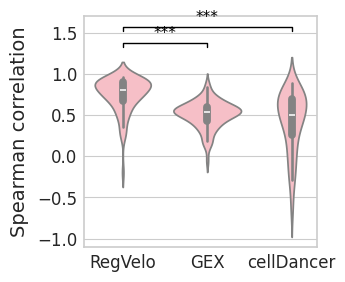

In [80]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3))
    # pal = {"RegVelo": "#0173b2", "veloVI": "#de8f05"}

    sns.violinplot(
        data=df,
        ax=ax,
        # orient="h",
        x="Method",
        y="Spearman correlation",
        order=["RegVelo", "GEX", "cellDancer"],
        color="lightpink",
    )

    ttest_res = ttest_ind(
        cor_rgv,
        cor_gex,
        equal_var=False,
        alternative="greater",
    )
    significance = get_significance(pvalue=ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(
        cor_rgv,
        cor_cd,
        equal_var=False,
        alternative="greater",
    )
    significance = get_significance(pvalue=ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=2,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    plt.xlabel("")

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "corr_sp.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()